In [1]:
# import zipfile

# f = zipfile.ZipFile("DRD_Split.zip",'r') # 压缩文件在jupyter中的位置
# for file in f.namelist():
#     f.extract(file,"DRD_Split_Cloud")               # 解压到的位置
# f.close()

In [2]:
# !pip install scipy

In [3]:
# # !pip install tensorflow-addons==0.18.0
# # !pip install scikit-learn
# !pip install seaborn


In [4]:
from tensorflow_addons.metrics import F1Score

In [5]:
import os
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization,Activation, concatenate, DepthwiseConv2D, Multiply,Dropout
from keras.layers import GlobalAveragePooling2D, Dense, MaxPooling2D,Flatten, Layer,BatchNormalization, Add,Reshape,AveragePooling2D

from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50V2, InceptionV3

from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt



In [6]:
input_shape = (224, 224, 3)

train_dir = r'C:\Users\MSI-PC\Desktop\Level 6 curriculum\Corsework\Machine Vision\Coursework\DR Datasets\DRD_Split\train'
test_dir = r'C:\Users\MSI-PC\Desktop\Level 6 curriculum\Corsework\Machine Vision\Coursework\DR Datasets\DRD_Split\test'

batch_size = 16
num_classes = 1
# filter_factor = 8

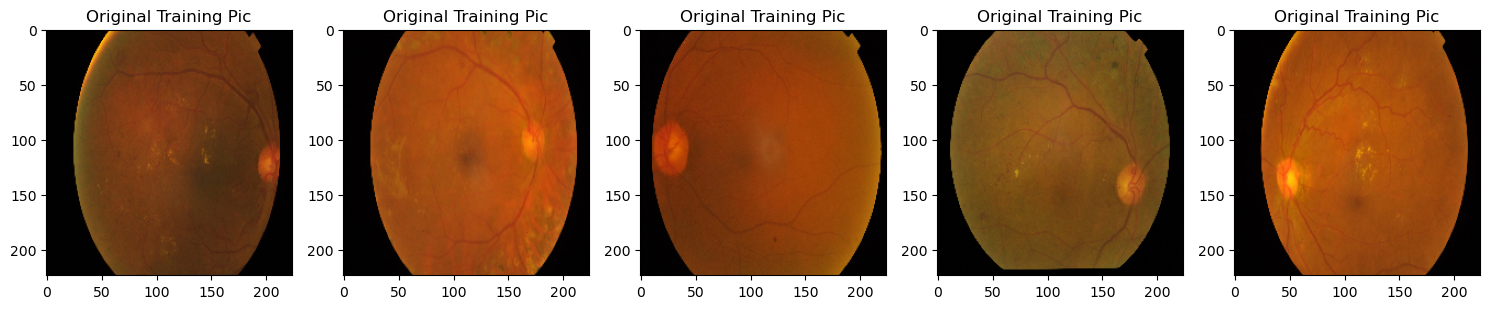

In [7]:
train_diabetic = r'C:\Users\MSI-PC\Desktop\Level 6 curriculum\Corsework\Machine Vision\Coursework\DR Datasets\DRD_Split\train\diabetic'

#Show the import original image
train_img_files = os.listdir(train_diabetic)
# test_img_files = os.listdir(test_dir)
# val_img_files = os.listdir(val_dir)

show_num = 5

plt.figure(figsize = (15, 5))

for i in range(show_num):
    
    img_path = os.path.join(train_diabetic, train_img_files[i])
    img = plt.imread(img_path)
    plt.subplot(1, show_num, i + 1)
    plt.imshow(img)
    plt.axis('on')
    plt.title("Original Training Pic")
    
plt.tight_layout()
plt.show()


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.13,  # Specify the validation split here
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess the training and testing images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # Use 'training' subset for training data
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # Use 'validation' subset for validation data
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'
)


Found 2708 images belonging to 2 classes.
Found 404 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


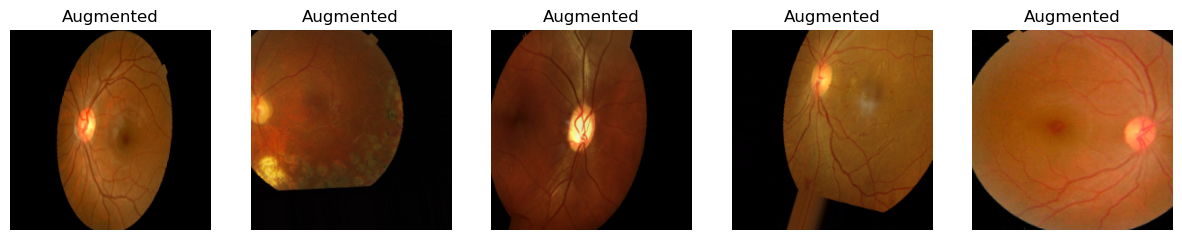

In [9]:
#To show the augmented pictures, after rotation, zoom in, rescale etc

# import scipy

# Extract a batch of images from the train_generator
sample_images, sample_labels = next(train_generator)

plt.figure(figsize = (15, 5))

# Show the original images from the batch
num_images_to_show = 5  # Show three images
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(sample_images[i-1])
    plt.title("Augmented")
    plt.axis('off')

In [10]:
model =ResNet50V2(weights ='imagenet', include_top=False, input_shape = input_shape)

In [11]:
for layer in model.layers:
    layer.trainable = False

#Adding custom Layers 
x = model.output

x = GlobalAveragePooling2D()(x)
outputs = Dense(1, activation="sigmoid")(x)

model_IR = Model(inputs=model.input, outputs = outputs)

In [12]:
model_IR.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)     

                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 7, 7, 256)    589824      ['conv4_block6_2_pad[0][0]']     
          

                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 7, 7, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 7, 7, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)  

In [13]:
lr = 0.001
Optimizer = Adam(learning_rate = lr)

from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow_addons.metrics import F1Score
from tensorflow.keras import backend as K


model_IR.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=[
        'accuracy', 
        Precision(), 
        Recall(), 
        AUC(), 
        F1Score(num_classes=1, average = 'micro')
    ]
)
lr_reduction = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,
                                patience = 10,
                                min_lr = 0.00001,
                                verbose = 1)
MODEL_NAME = "ResNet50V2_123123"  # 用您的模型名替换
# 训练合并后的模型
csv_logger = tf.keras.callbacks.CSVLogger(
    fr"C:\Users\MSI-PC\Desktop\Level 6 curriculum\Corsework\Machine Vision\Final Codes\Final Test\HistoryCSV\{MODEL_NAME}.csv", 
    separator=",", 
    append=False)

history = model_IR.fit(
    train_generator,
    epochs=100,  # 根据需要调整epochs数
    validation_data=validation_generator,
    callbacks=[csv_logger, lr_reduction]  # 添加 ModelCheckpoint 到回调列表
)



Epoch 1/100
170/170 [==============================] - 40s 200ms/step - loss: 0.2963 - accuracy: 0.8852 - precision: 0.8815 - recall: 0.8861 - auc: 0.9501 - f1_score: 0.6604 - val_loss: 0.1881 - val_accuracy: 0.9332 - val_precision: 0.9019 - val_recall: 0.9698 - val_auc: 0.9858 - val_f1_score: 0.6600 - lr: 0.0010
Epoch 2/100
170/170 [==============================] - 32s 190ms/step - loss: 0.1983 - accuracy: 0.9332 - precision: 0.9261 - recall: 0.9393 - auc: 0.9753 - f1_score: 0.6604 - val_loss: 0.1458 - val_accuracy: 0.9554 - val_precision: 0.9415 - val_recall: 0.9698 - val_auc: 0.9883 - val_f1_score: 0.6600 - lr: 0.0010
Epoch 3/100
170/170 [==============================] - 32s 188ms/step - loss: 0.1754 - accuracy: 0.9424 - precision: 0.9325 - recall: 0.9521 - auc: 0.9796 - f1_score: 0.6604 - val_loss: 0.1489 - val_accuracy: 0.9455 - val_precision: 0.9234 - val_recall: 0.9698 - val_auc: 0.9866 - val_f1_score: 0.6600 - lr: 0.0010
Epoch 4/100
170/170 [==============================] - 

Epoch 27/100
170/170 [==============================] - 32s 189ms/step - loss: 0.1118 - accuracy: 0.9631 - precision: 0.9557 - recall: 0.9700 - auc: 0.9915 - f1_score: 0.6604 - val_loss: 0.1065 - val_accuracy: 0.9653 - val_precision: 0.9744 - val_recall: 0.9548 - val_auc: 0.9939 - val_f1_score: 0.6600 - lr: 0.0010
Epoch 28/100
170/170 [==============================] - 32s 188ms/step - loss: 0.1169 - accuracy: 0.9609 - precision: 0.9522 - recall: 0.9693 - auc: 0.9903 - f1_score: 0.6604 - val_loss: 0.1250 - val_accuracy: 0.9629 - val_precision: 0.9742 - val_recall: 0.9497 - val_auc: 0.9930 - val_f1_score: 0.6600 - lr: 0.0010
Epoch 29/100
170/170 [==============================] - 32s 187ms/step - loss: 0.1161 - accuracy: 0.9594 - precision: 0.9514 - recall: 0.9670 - auc: 0.9904 - f1_score: 0.6604 - val_loss: 0.1191 - val_accuracy: 0.9604 - val_precision: 0.9598 - val_recall: 0.9598 - val_auc: 0.9916 - val_f1_score: 0.6600 - lr: 0.0010
Epoch 30/100
170/170 [==============================

KeyboardInterrupt: 

In [ ]:
# history = model_IR.fit(train_generator, epochs = 100, validation_data=(validation_generator), callbacks = [lr_reduction, early_stopping])

In [ ]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')

plt.subplot(2, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

plt.subplot(2, 3, 3)
plt.plot(history.history['precision_1'])
plt.plot(history.history['val_precision_1'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training Precision', 'Validation Precision'], loc='lower right')


plt.subplot(2, 3, 4)
plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Training Recall', 'Validation Recall'], loc='lower right')

plt.subplot(2, 3, 5)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend(['Training F1-Score', 'Validation F1-Score'], loc='lower right')

plt.subplot(2, 3, 6)
plt.plot(history.history['auc_1'])
plt.plot(history.history['val_auc_1'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training AUC', 'Validation AUC'], loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
# import numpy as np
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# # 收集图像和真实标签
# all_images, all_true_labels = zip(*[next(test_generator) for _ in range(test_generator.samples // test_generator.batch_size)])
# all_images = np.concatenate(all_images)
# all_true_labels = np.argmax(np.concatenate(all_true_labels), axis=1)

# # 进行预测并获取预测标签
# predictions = ensemble_model.predict(all_images)
# predicted_labels = np.argmax(predictions, axis=1)

# # 生成并绘制混淆矩阵
# conf_matrix = confusion_matrix(all_true_labels, predicted_labels)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.show()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 收集图像和真实标签
all_images, all_true_labels = zip(*[next(test_generator) for _ in range(test_generator.samples // test_generator.batch_size + 1)])
all_images = np.concatenate(all_images)
all_true_labels = np.concatenate(all_true_labels)

# 进行预测并获取预测标签
predictions = model_IR.predict(all_images)
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

# 生成并绘制混淆矩阵
conf_matrix = confusion_matrix(all_true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



In [ ]:
from sklearn.metrics import f1_score


# 计算F1-Score
f1 = f1_score(all_true_labels, predicted_labels, average='macro')

print("F1-Score:", f1)


f1_each_class = f1_score(all_true_labels, predicted_labels, average=None)
print("F1-Score for each class:", f1_each_class)


In [ ]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(all_true_labels, predicted_labels)

#compute the AUC score
roc_auc= auc(fpr, tpr)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate 
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)

In [ ]:
# from sklearn.metrics import precision_recall_curve

# # 计算预测概率
# ensemble_pred_probs = model_IR.predict(all_images)

# # 获取预测正类的概率
# # 假设是二分类问题，并且正类是第二个类别
# positive_class_probs = ensemble_pred_probs[:, 1]

# # 计算 Precision 和 Recall
# precision, recall, thresholds = precision_recall_curve(all_true_labels, positive_class_probs)

# plt.figure(figsize=(8, 8))
# plt.plot(recall, precision, color='b')
# plt.title('Precision-Recall Curve')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.show()
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# 计算预测概率
ensemble_pred_probs = model_IR.predict(all_images)

# 对于二分类 sigmoid 输出，模型直接输出的是正类的概率
positive_class_probs = ensemble_pred_probs.ravel()

# 计算 Precision 和 Recall
precision, recall, thresholds = precision_recall_curve(all_true_labels, positive_class_probs)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='b')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()



In [ ]:
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1_score = model_IR.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test AUC:', test_auc)
print('Test F1 Score:', test_f1_score)

In [ ]:
# from sklearn.metrics import classification_report

# # 使用模型对验证集进行预测，获取预测概率
# y_pred_probs = model_IR.predict(all_images)

# # 将预测概率转换为类别标签
# y_pred_labels = np.argmax(y_pred_probs, axis=1)

# # 假设 y_val 是真实标签，并且也是类别标签形式
# # 现在您可以生成分类报告
# report = classification_report(all_true_labels, y_pred_labels)
# print(report)

from sklearn.metrics import classification_report

# 使用模型对验证集进行预测，获取预测概率
y_pred_probs = model_IR.predict(all_images)

# 对于二分类任务，使用阈值 0.5 将预测概率转换为类别标签
y_pred_labels = (y_pred_probs > 0.5).astype(int).reshape(-1)

# 假设 all_true_labels 是真实标签
# 现在您可以生成分类报告
report = classification_report(all_true_labels, y_pred_labels, target_names=['Class 0', 'Class 1'])
print(report)


In [ ]:
import pandas as pd


# Generate a classification report (replace this with your actual data)
report = classification_report(all_true_labels, y_pred_labels, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# Drop the 'support' column, as it's not suitable for the heatmap
report_df = report_df.drop(columns=['support'])

# Draw the heatmap with the default colormap
plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cbar=False)
plt.title("Classification Report")
plt.show()



def generate_grad_cam(ensemble_model, img_array, target_layer, output_layer):
    grad_model = Model(
        [ensemble_model.inputs],
        [ensemble_model.get_layer(target_layer).output, ensemble_model.get_layer(output_layer).output]
    )

    with tf.GradientTape() as tape:
        conv_output, model_output = grad_model(img_array)
        loss = model_output[:, 1]  
    grads = tape.gradient(loss, conv_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)

    heatmap /= np.max(heatmap)
    return heatmap

output_layer_name1 = model1.output.name.split("/")[0]
output_layer_name2 = model2.output.name.split("/")[0]

num_images = 5

for i in range(num_images):
    batch = next(test_generator)

    img_array = batch[0]
    label = batch[1]
    #conv2d_8,multiply_9 ,multiply_10,add_3 (Add)

    heatmap1 = generate_grad_cam(model1, img_array, 'conv2d_8', output_layer_name1)
    heatmap2 = generate_grad_cam(model2, img_array, 'add_3', output_layer_name2)

    target_size = max(heatmap1.shape[0], heatmap2.shape[0]), max(heatmap1.shape[1], 
                                                                                    heatmap2.shape[1])
    heatmap1_resized = tf.image.resize(heatmap1[..., np.newaxis], target_size)[..., 0]
    heatmap2_resized = tf.image.resize(heatmap2[..., np.newaxis], target_size)[..., 0]
    # heatmap3_resized = tf.image.resize(heatmap3[..., np.newaxis], target_size)[..., 0]
    
    heatmap = (heatmap1_resized + heatmap2_resized) / 2.0

    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (224, 224))[..., 0]
    heatmap_weighted = heatmap_resized * 1

    weighted_img = heatmap_weighted[..., np.newaxis] * img_array[0]
    weighted_img /= np.max(weighted_img) 

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img_array[0])
    plt.title(f'Original Image (Label: {label[0]})')

    plt.subplot(1, 3, 2)
    plt.imshow(weighted_img[..., 0],cmap='jet')
    plt.title('Weighted Image')

    plt.show()


In [ ]:
#delete the model to prevent memory costs

from keras import backend as K
import gc

K.clear_session()
gc.collect()

del model_IR


from numba import cuda

cuda.select_device(0)
cuda.close()